<B>CMSC641 - Fall 2017 - Final Project Part 2 - Holt</B>

<P>
<B>Analysis of Sentiment towards Bitcoin</B>
<P>
<B>Research Question: </B>
<B>How does the sentiment in news and social media coverage of Bitcoin correlate to changes in Bitcoin price?</B>

To answer this we use two sources of data. 

<B>First data source:  Event Registry</b><br>
First, we retrieve articles from EventRegistry via their API.
EventRegistry.org collects and analyzes news articles published by over 30,000 news publishers worldwide, and provides an API by which we can search, filter and retrieve articles and associated metadata.  They also provide software tools for annotating and measuring sentiment of text such as articles. I had built methods to use this sentiment analysis, <i>but</i> unfortunately it has stopped working.  I'm reverting to using the NLTK code from one of the previous projects, but that code is painfully slow. 
<P>
More info here:
<pre>
 https://eventregistry.org/
 https://github.com/EventRegistry/event-registry-python
 https://github.com/EventRegistry/event-registry-python/wiki
</pre>

Using this API we can retrieve articles related to the Bitcoin concept for a specified date range. 

We then use NLTK to do sentiment analysis on each article, producing a sentiment score indicating positive, negative or neutral sentiment. 

<B>Second data source:  </b><br>

Secondly, we retrieve historic Bitcoin price data here: 
<pre>
https://bitcoincharts.com/charts/coinbaseUSD#rg180zigHourlyztgCzm1g10zm2g25
</pre>
This file contains six months of hourly bitcoin price data from the GDAX (Coinbase) exchange. 
The file contains the following fields (tab delimited):
<pre>
     Timestamp, Open, High, Low, Close, Volume (BTC), Volume (Currency), Weighted Price
</pre>
We will extract timestamp and close (closing price for that hour), and use them to compare against sentiment scores. 



In [1]:
import nltk
import nltk.data

In [10]:
import nltk.sentiment
nltk.download('opinion_lexicon')

nltk.sentiment.util.demo_liu_hu_lexicon('this is a fantastic statement', plot=False)

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/jamesholt/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
Positive


In [3]:
# define a function that measures the sentiment of a block of text. In this case we will feed it an article body. 

def getsentiment(txt):
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank
    import re
    
    txt = re.sub('\.',' . ',txt) # mark negation doesn't work if the period is directly after a word, add a space
    
    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(txt)]

    tokenized_sent = nltk.sentiment.util.mark_negation(tokenized_sent)
    
    x = list(range(len(tokenized_sent)))
    y = []

    score = 0
    
    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1) # negative
        else:
            y.append(0) # neutral

    avgy = sum(y) / float(len(y))    

#    return pos_words, neg_words, len(y), avgy
    return avgy
    
#sentencelean("I didn't like this movie . It was bad .  But the score was good .")
getsentiment("I didn't hate this movie . It was decent")

0.1

In [4]:
!pip3 install eventregistry

In [9]:
import eventregistry as ER
from eventregistry import *

from datetime import datetime
from dateutil import rrule
from datetime import timedelta

import statistics

# NOTE:  this is the API key associated with my (free) account at EventRegistry.org.  You may use it to test this
# code but please do not redistribute or use for other purposes.  If you are interested it is easy and free to set
# up an account and get your own API key.  (There is also a pay version that allows querying for more articles and
# some additional functionality.  I have not tried the pay version.)
er = EventRegistry(apiKey = '51910533-191b-4255-b221-b6c43d01aeb1')

btc = er.getConceptUri("Bitcoin")
#analytics = ER.Analytics(er)

articlesperhour = 5 # max articles to query per hour

def getHourSentiment(startdt):

    enddt = startdt + timedelta(hours=1)

    print('querying with:  startdt: '+str(startdt)+" enddt: "+str(enddt))
    
    q = QueryArticlesIter(
            # set the date range
            dateStart = startdt, dateEnd = enddt,
            # find articles related to our concept
            conceptUri = btc,
            # retrieve only articles in specified language
            lang="eng"
    )

    qc = q.count(er)
    print("article count for this hour: "+str(qc))
    print("top "+str(articlesperhour)+" articles:")
    
    if qc == 0: 
        return 0
    
    sens = []
    for art in q.execQuery(er, sortBy="date", maxItems=articlesperhour):
        #ann = analytics.sentiment(art["body"])
        #print('{:f}'.format(ann["avgSent"]) + " : " + str(art["title"]))
        
        sentiment = getsentiment(art["body"])
        print('{:f}'.format(sentiment) + " : " + str(art["title"]))
        sens.append(sentiment)
    
    avg_sen = statistics.mean(sens)
    
    return avg_sen

# start_dt = datetime.strptime('2017-12-11 00:00:00', '%Y-%m-%d %H:%M:%S')
# sen = getHourSentiment(start_dt)
# print(str(sen))

# start_dt = datetime.strptime('2017-12-18 00:00:00', '%Y-%m-%d %H:%M:%S')
# sen = getHourSentiment(start_dt)
# print(str(sen))


using user provided API key for making requests
Event Registry host: http://eventregistry.org
querying with:  startdt: 2017-12-11 00:00:00 enddt: 2017-12-11 01:00:00
article count for this hour: 1280
top 5 articles:
0.021721 : 7 of the Best Bank Stocks to Buy for 2018
-0.000971 : Business Highlights
0.000000 : Wall Street closes higher ahead of Fed meeting; stocks rise worldwide | Reuters
-0.003614 : Bitcoin's First 24 Hours on Wall Street Feed Euphoria and Doubts
0.002068 : Asian investors embrace bitcoin, but regulators are wary | MACAU DAILY TIMES 澳門每日時報
0.003840777959688188
querying with:  startdt: 2017-12-18 00:00:00 enddt: 2017-12-18 01:00:00
article count for this hour: 688
top 5 articles:
-0.014914 : 'Extremely high risk': bitcoin.com co-founder has sold all his bitcoins
0.011532 : Global Markets: Asian shares rise amid U.S. tax cut hopes; China in focus
0.003683 : Bitcoin hits bigger stage as exchange giant CME launches futures
-0.013761 : 'Extremely high risk': bitcoin.com co

In [19]:
# for the time period we are examining, query each hour to get the sentiment

from datetime import datetime
from dateutil import rrule
from datetime import timedelta

start_dt = datetime.strptime('2017-12-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end_dt   = datetime.strptime('2017-12-01 02:00:00', '%Y-%m-%d %H:%M:%S')

hoursentiment = {} # a dict holding sentiment for each hour

for dt in rrule.rrule(rrule.HOURLY, dtstart=start_dt, until=end_dt):
    #print(str(dt) + " : " + str(dtplus))
    hoursentiment[dt] = getHourSentiment(dt)
    print("average sentiment for this hour: " + str(hoursentiment[dt]))

    

querying with:  startdt: 2017-12-01 00:00:00 enddt: 2017-12-01 01:00:00
article count for this hour: 490
top 5 articles:
-0.001794 : As Bitcoin surges, investors warn of Longmont-based TEH
0.031142 : Buying cryptocurrency at a discount price dashgold is going to be launched
0.004425 : Bitcoin rebounds to US$10,500 after US regulator approves futures
0.031039 : With blockchain, Berkeley student group sets standard
0.021978 : Sidechains Project Pushes Ahead with Bitcoin BIP Submission - CoinDesk
average sentiment for this hour: 0.017358016716078936
querying with:  startdt: 2017-12-01 01:00:00 enddt: 2017-12-01 02:00:00
article count for this hour: 490
top 5 articles:
-0.001794 : As Bitcoin surges, investors warn of Longmont-based TEH
0.031142 : Buying cryptocurrency at a discount price dashgold is going to be launched
0.004425 : Bitcoin rebounds to US$10,500 after US regulator approves futures
0.031039 : With blockchain, Berkeley student group sets standard
0.021978 : Sidechains Project 

Now we have sentient from articles published for each hour.  Let's get price data to compare that to. 


Historic Bitcoin price data is in a file that was retrieved from here: 
https://bitcoincharts.com/charts/coinbaseUSD#rg180zigHourlyztgCzm1g10zm2g25

This file contains six months of hourly bitcoin price data from the GDAX (Coinbase) exchange. 
The file contains fields (tab delimited):
<pre>     Timestamp, Open, High, Low, Close, Volume (BTC), Volume (Currency), Weighted Price </pre>
We will extract timestamp and close (closing price for the hour specified). 

In [15]:
# read in historic bitcoin prices by hour from the file

from datetime import datetime

file = open("./ProjectFinal/data/btc6mo.txt","r",encoding="latin-1")
ln = file.readline()

btc_hr_list = []  # a list
btc_hr_dict = {}  # a dict

counter = 0

while True:
        ln = file.readline()
        if not ln: break

        splist = ln.split('\t')
        ts = datetime.strptime(splist[0], '%Y-%m-%d %H:%M:%S')
    
        if splist[4].isnumeric():
            btc_hr_list.append([splist[0],splist[4]])
            btc_hr_dict[ts] = float(splist[4])

        counter += 1

        if counter % 100000 == 0:
            print(str(counter))

file.close        

print('done')
# print(btc_hr_list)
# print(btc_hr_dict)

done


In [16]:
# create a dataframe with the btc price dict

import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
#import numpy

btc_hr_df = pandas.DataFrame.from_records({"btc_hr":btc_hr_dict})


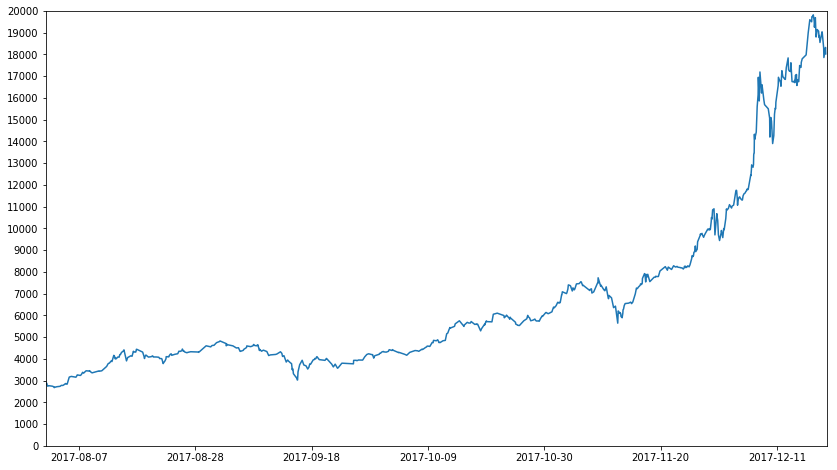

In [17]:
# make a chart showing BTC hourly price over our time period

import numpy
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

plt.clf() # clear any previously plotted stuff from the plot
plt.xlim(pandas.Timestamp('2017-08-01 00:00:00'), pandas.Timestamp('2017-12-20 00:00:00'))
plt.ylim([0,200])
plt.yticks( numpy.arange(0,20001,1000) )
plt.plot(btc_hr_df)
plt.show()


In [ ]:
# Now, plot the sentiment and the price together, to get a visual feel for how correlated they are

# I am unable to do this right now because my sentiment analysis code is so slow.  It is taking too long to do analysis 
# on 5 articles for each hour in our timeframe.  With more time could definitely resolve this by building code better 
# than what is available in the NLTK library, or finding APIs to do this faster. 


# Next, apply statistical analysis techniques to measure correlation between the sentiment data and the price data. 

# Also unable to do this right now. 
